In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time

import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 9)

In [91]:
def random_neural_network(N=1000, sigma=5, iterations=400, seed=None):
    orig_pert = 0.001
    np.random.seed(seed)
    J = np.random.normal(scale=sigma/np.sqrt(N), size=(N, N))
    x = np.zeros((iterations, N))
    delta_x = np.zeros((iterations, N))
#     x[0] = np.random.normal(scale=sigma/np.sqrt(N), size=N)
    x[0][int(N/2)] = orig_pert

    for t in range(1, iterations):
        x[t] = np.dot(J, np.tanh(x[t-1]))
        delta_x[t] = x[t] - x[t-1]
        if t % 100 == 0:
            print("Iteration {t}".format(t=t))
    
    return x, N, delta_x[500:] / orig_pert, orig_pert

def analysis(x, size):
    for z in range(0, size, int(np.ceil(size/100))):
        plt.plot(x[:, z])
    plt.xlabel("Time")
    plt.ylabel("Neuron Value")
    plt.show()

In [90]:
x, size, delta_x, orig_pert = random_neural_network(N=1000, sigma=1.1, iterations=1000)

Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900


[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [ -3.18528453e-03  -3.40177349e-02   4.16454323e-02 ...,  -2.75045998e-02
   -2.47532631e-03  -1.59998776e-02]
 [ -1.71455979e-02   7.71163087e-02  -7.30619504e-02 ...,   4.64664066e-02
    2.21063399e-02  -6.98043299e-03]
 ..., 
 [  2.76469733e+02  -5.14194979e+02   8.01133465e+01 ...,  -8.82473817e+01
   -5.75897378e+02  -4.86181342e+02]
 [  9.50278137e+01  -5.50407025e+02  -2.82058298e+02 ...,   5.93798970e+02
   -7.91414767e+02   2.71102547e+01]
 [  3.15198337e+02   9.00998019e+02  -4.05476301e+00 ...,  -7.29906412e+02
    9.57251782e+02   4.09327552e+02]]


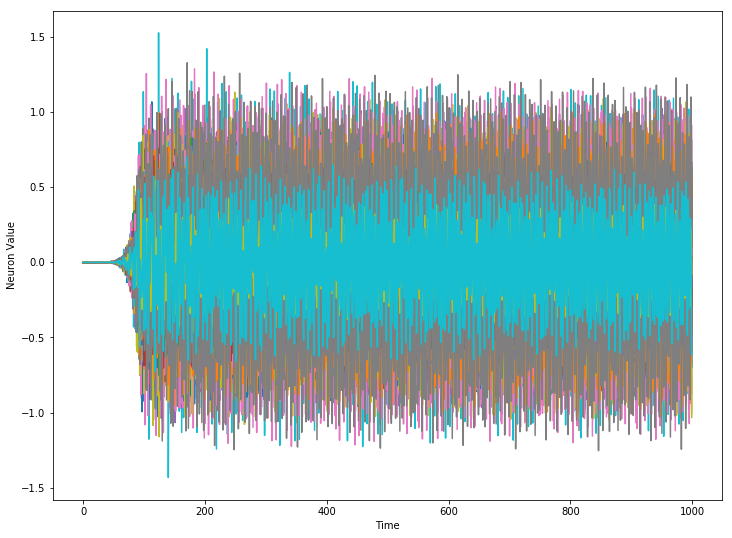

In [92]:
print(delta_x)

analysis(x, size)

Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900


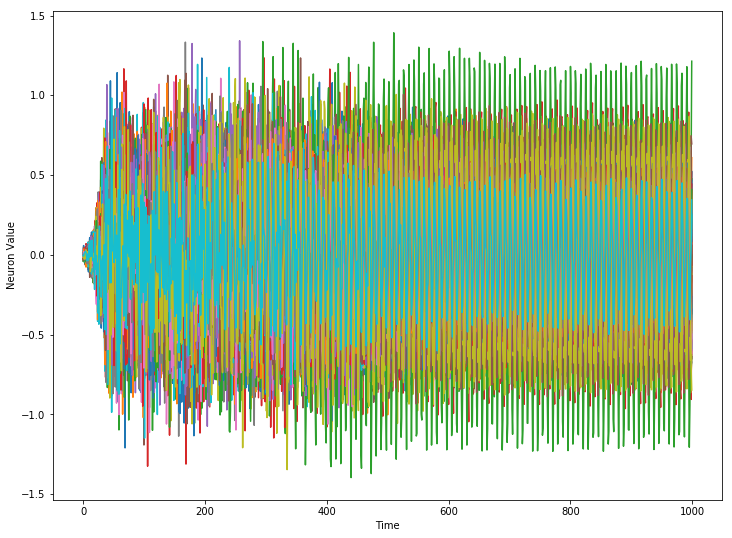

In [29]:
x, size = random_neural_network(N=5000, sigma=1.1, iterations=1000)
analysis(x, size)

In [70]:
class Particle:
    def __init__(self, its, x=4, y=4, vx=1/np.sqrt(2), vy=1/np.sqrt(2), delta_t=0.1):
        self.delta_t = delta_t
        self.its = its
        self.x = np.zeros(its)
        self.y = np.zeros(its)
        self.vx = np.zeros(its)
        self.vy = np.zeros(its)
        self.x[0] = x
        self.y[0] = y
        self.vx[0] = vx
        self.vy[0] = vy
    
    def update(self, t, gx, gy):
        # For dissipative force  * np.exp(-t/(20*self.its))
        self.vx[t] = self.vx[t-1] - gx * self.delta_t
        self.vy[t] = self.vy[t-1] - gy * self.delta_t
        self.x[t] = self.x[t-1] + self.vx[t] * self.delta_t
        self.y[t] = self.y[t-1] + self.vy[t] * self.delta_t
        if self.x[t] > 10:
            self.x[t] = 10
            self.vx[t] *= -1
        elif self.x[t] < 0:
            self.x[t] = 0
            self.vx[t] *= -1 
        if self.y[t] > 10:
            self.y[t] = 10
            self.vy[t] *= -1
        elif self.y[t] < 0:
            self.y[t] = 0
            self.vy[t] *= -1 


def detect_local_minima(arr):
    # http://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array/3689710#3689710
    """
    Takes an array and detects the troughs using the local maximum filter.
    Returns a boolean mask of the troughs (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    # define an connected neighborhood
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#generate_binary_structure
    neighborhood = morphology.generate_binary_structure(len(arr.shape),2)
    # apply the local minimum filter; all locations of minimum value 
    # in their neighborhood are set to 1
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.filters.html#minimum_filter
    local_min = (filters.minimum_filter(arr, footprint=neighborhood)==arr)
    # local_min is a mask that contains the peaks we are 
    # looking for, but also the background.
    # In order to isolate the peaks we must remove the background from the mask.
    # 
    # we create the mask of the background
    background = (arr<=0.01)
    # 
    # a little technicality: we must erode the background in order to 
    # successfully subtract it from local_min, otherwise a line will 
    # appear along the background border (artifact of the local minimum filter)
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#binary_erosion
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    # 
    # we obtain the final mask, containing only peaks, 
    # by removing the background from the local_min mask
    detected_minima = local_min - eroded_background
#     print(np.where(detected_minima)[0])
    return len(np.where(detected_minima)[0])
            
def simulate(n, q):
    seed = int(time.time())
    # seed = 1489423116
    # seed = 1489423403
#     np.random.seed(seed)
    print(seed)
    x = y = np.linspace(0, 10, 101)
    pos = np.dstack(np.meshgrid(x, y))
    
    lyapunov_exp = np.zeros(n)
    no_minima = np.zeros(n)
    
    for k in range(n):
        # Build landscape
#         print(k)
        f = 0
        for m in range(q):
            f += sp.multivariate_normal.pdf(pos, mean=[np.random.random()*10, np.random.random()*10], cov=[[0.4, 0], [0, 0.4]])

        no_min = detect_local_minima(f)
        no_minima[k] = no_min
        its = 100
        particles = [Particle(its), Particle(its, x=4.1)]

        delta_x = delta_y = 0.1
        gy, gx = np.gradient(f, delta_x, delta_y)

        for t in range(1, its):
            for p in particles:

                gx_t = gx[int(np.floor(p.y[t-1]/0.1)) - 1, int(np.floor(p.x[t-1]/0.1)) - 1]
                gy_t = gy[int(np.floor(p.y[t-1]/0.1)) - 1, int(np.floor(p.x[t-1]/0.1)) - 1]
                p.update(t, gx_t, gy_t)
        
#         plt.contourf(np.linspace(0, 10, 101), np.linspace(0, 10, 101), f)
#         plt.xlabel("x")
#         plt.ylabel("y")
#         for p in particles:
#             plt.plot(p.x, p.y)
#             plt.plot(p.x[0], p.y[0], 'ro')
#         plt.show()

#         for p in particles:
#             plt.plot(range(len(p.vx)), np.sqrt(p.vx**2 + p.vy**2))
#         plt.show()

#         fig = plt.figure()
#         ax = fig.gca(projection='3d')
#         ax.view_init(elev=70, azim=60)
#         x, y = np.meshgrid(np.linspace(0, 10, 101), np.linspace(0, 10, 101))
#         ax.plot_surface(x, y, f, cmap=cm.viridis)
#         ax.set_xlabel("x")
#         ax.set_ylabel("y")
#         plt.show()
        
#         fig = plt.figure()
#         ax = fig.gca(projection='3d')
#         ax.view_init(elev=70, azim=60)
#         x, y = np.meshgrid(np.linspace(0, 10, 101), np.linspace(0, 10, 101))
#         ax.plot_surface(x, y, gx, cmap=cm.viridis)
#         ax.set_xlabel("x")
#         ax.set_ylabel("y")
#         plt.show()
        diff = np.sqrt((particles[0].x - particles[1].x)**2 + (particles[0].y - particles[1].y)**2)
#         plt.plot(range(len(p.vx))[:100], np.log(diff)[:100])
        lyapunov_exp[k] = np.polyfit(range(len(p.vx))[:100], np.log(diff)[:100], 1)[0]
    
    return no_minima, lyapunov_exp
        
av_lyap = []
mini = []
for t in range(1, 100, 5):
    mini.append(t)
    n, l = simulate(100, t)
    av_lyap.append(np.mean(l))
    

1489579809


/Users/teun/anaconda3/envs/3point6/lib/python3.6/site-packages/ipykernel/__main__.py:64: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


1489579810
1489579811
1489579813
1489579816
1489579819
1489579823
1489579828
1489579834
1489579840
1489579846
1489579854
1489579862
1489579871
1489579881
1489579892
1489579903
1489579914
1489579927
1489579940


[1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96]
[0.00051452811668943274, 0.0056893057406617979, 0.011714365864134204, 0.013024684918248512, 0.014737398986296795, 0.018059297234167885, 0.016925364721847445, 0.019587759592848669, 0.018609199798797767, 0.019239560195163895, 0.022153851613631228, 0.02149951278290561, 0.022678166625780389, 0.02211721523784815, 0.023213701094144109, 0.024105780825256353, 0.02234436971537037, 0.023826343804521692, 0.023239485874851223, 0.025794823129155174]
[ 0.00572629 -0.00175997]


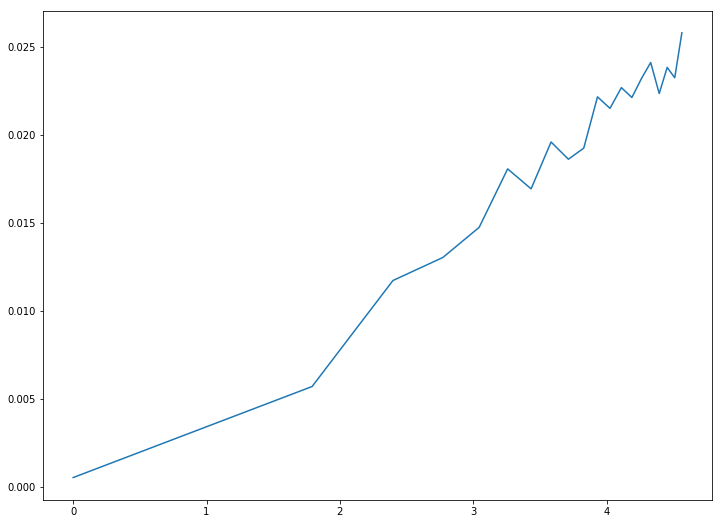

In [72]:
print(mini)
print(av_lyap)
x = np.asarray(mini)
y = np.asarray(av_lyap)
plt.plot(np.log(x), y)
p = np.polyfit(np.log(x), y, 1)
print(p)
plt.show()

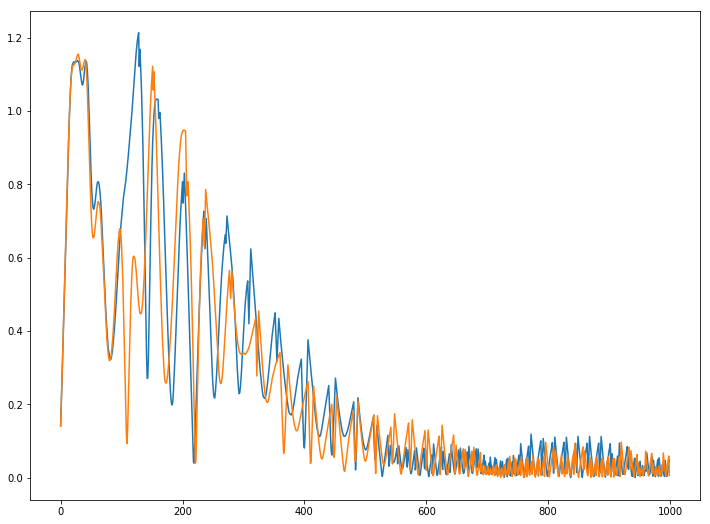

[ 0.01093206 -2.91476993]


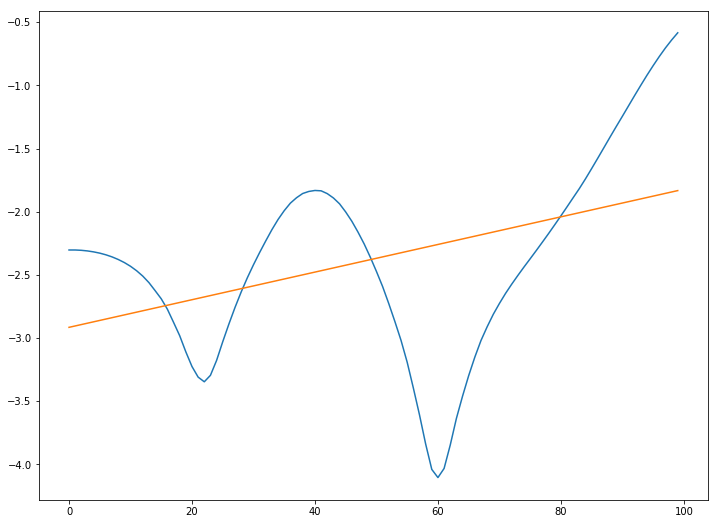

In [36]:
for p in particles:
    plt.plot(range(len(p.vx)), np.sqrt(p.vx**2 + p.vy**2))
plt.show()

diff = np.sqrt((particles[0].x - particles[1].x)**2 + (particles[0].y - particles[1].y)**2)
plt.plot(range(len(p.vx))[:100], np.log(diff)[:100])
po = np.polyfit(range(len(p.vx))[:100], np.log(diff)[:100], 1)
print(po)
plt.plot(range(len(p.vx))[:100], np.polyval(po, range(len(p.vx))[:100]))
plt.show()